# Autoencoders 

Autoencoders also perform feature transformation. We will showcase the autoencoder approach on the same dataset as before.

Click on the button below to open this notebook in the Colab environment.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/DimRed-Course/blob/main/notebooks/2_autoencoders.ipynb)

Once you are in Colab, run the cell below to access the respective folder in your Google Colab files.

In [ ]:
!git clone https://github.com/HelmholtzAI-Consultants-Munich/DimRed-Course.git
%cd DimRed-Course/notebooks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import plot_components
from sklearn.preprocessing import StandardScaler

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
scaler = StandardScaler().set_output(transform="default")
data = scaler.fit_transform(data_original)

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras

Autoencoders are **neural networks that learn low-dimensional latent representations from which the original data can be reconstructed as well as possible**, i.e. minimizing the loss given below.

<center><img src="./figures/autoencoder1.png" width="500"/></center>

The latent representation is a feature representation of reduced dimensionality. Autoencoders consist of an encoder and a decoder part. The **encoder** uses multiple layers to compress the original features into new features, i.e. it is a deep neural network. Layers take a weighted sum of input features and transform it via a nonlinear activation function to produce an output. The weight initialization is done with the Xavier method, also called glorot_normal (we will not go into details during this course, see e.g. [this  post](https://www.deeplearning.ai/ai-notes/initialization/index.html) if you are interested). The **decoder** uses multiple layers to expand the latent representation into the original feature space. The encoder and decoder are trained together. The final layers are chosen to be linear (i.e., activation=None) to be expressive enough to cover the whole value range.

In [4]:
# Building blocks
def build_encoder(inputs, layer_sizes, n_components):
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    x = Dense(n_components, activation=None, kernel_initializer='glorot_normal', name='encoder_output')(x)
    encoder = Model(inputs, x, name='encoder')
    return encoder

def build_decoder(X, layer_sizes, n_components):
    latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
    x = latent_inputs
    for size in layer_sizes[::-1]:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = Dense(X.shape[1], activation=None, kernel_initializer='glorot_normal', name='decoder_output')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

We will apply an autoencoder approach to reduce the dimensionality of the tomato gene expression dataset. For computational efficiency, we will use here only the first 500 genes, so the following call reduces 500-dimensional profiles to two-dimensional profiles.

Model: "ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 2)                   │          75,026 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 500)                 │          75,524 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,550 (588.09 KB)

 Trainable params: 150,550 (588.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.9068
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.9051
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.9038
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.9019
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.8990
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.8952
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8898
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.8831
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.8750
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.8659
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.8562
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8465
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8367
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8264
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8157
Epoch 16/200


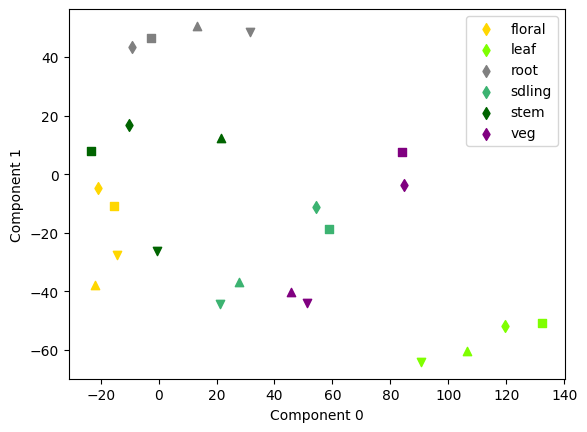

In [6]:
# Basic autoencoder
def autoencoder(X, n_components=2):  

    layer_sizes = [128,64,32,16]
    inputs = Input(shape=(X.shape[1],), name='encoder_input')

    encoder = build_encoder(inputs, layer_sizes, n_components)
    decoder = build_decoder(X, layer_sizes, n_components)
    
    ae = Model(inputs, decoder(encoder(inputs)), name='ae')
    print(ae.summary())

    ae.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), run_eagerly=False) 
    ae.fit(x=X,y=X, epochs=200, verbose=1, batch_size=24)
    
    Y_AE = encoder.predict(X)
    return Y_AE
    
keras.utils.set_random_seed(42) 
Y_AE = autoencoder(data[:,range(500)])
plot_components(Y_AE)


The latent representation obtained from the autoencoder separates some tissues from each other, while other tissues get very close or overlap.

Next, we will try a **variational autoencoder**. This is an autoencoder that uses **regularization** during training to ensure that the latent space has certain properties. For that purpose, the loss function is composed of a reconstruction term (for the final layer) and a regularization term (for the latent layer). For variational autoencoders, the regularization happens by encoding instances not as single points but as distributions over the latent space and by encouraging these distributions via the regularization loss to be close to standard normal distributions.

More precisely, from an instance x the encoder does not produce anymore directly a latent representation z, but **a mean and a covariance matrix from which the latent representation z is sampled**. In the following implementation the covariance matrix is diagonal, corresponding to uncorrelated latent components. The sampled z is then used as an input for the decoder during the training, and the reconstruction loss is computed based on the decoder output. This procedure has the effect that slightly different decoder inputs will lead to similar decoder outputs. That means, the sampling approach itself ensures robustness and a meaningful organization of the latent space. 

However, this is only true if it is a real sampling step and **not degenerated due to very tiny variances or very far apart means**. Therefore, we include a **regularization loss** that is the Kullback-Leibler divergence between the mean and covariance matrix produced by the encoder and a standard Gaussian distribution with **0** mean and identity matrix, averaged across all data instances. There is a tradeoff between regularization loss and reconstruction loss, which can be controled via a weight factor w.

<center><img src="./figures/autoencoder2.png" width="600"/></center>

If this short summary does not satisfy your needs, here is [a more elaborate post](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73).

In [6]:
# Further building blocks
def build_variational_encoder(inputs, layer_sizes, n_components, myseed):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.random.normal(shape=z_mean.size(), seed=myseed)
        return z_mean + keras.ops.exp(z_log_var) * epsilon
    
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)

    z_mean = Dense(n_components, kernel_initializer='glorot_normal', name='latent_mean')(x)
    z_log_var = Dense(n_components, kernel_initializer='glorot_normal', name='latent_sigma')(x)

    z = Lambda(sampling, output_shape=(n_components,))([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.regularization_loss_tracker = keras.metrics.Mean(name="regularization_loss")

    def train_step(self, x):
        
        self.zero_grad()
        
        z_mean, z_log_var, z = self.encoder(x)
        x_decoded_mean = self.decoder(z)

        mse = keras.losses.MeanSquaredError()
        reconstruction_loss = mse(x, x_decoded_mean) # equivalent to keras.ops.mean(keras.ops.mean(keras.ops.square(x-x_decoded_mean), axis=1))
        kl_loss = - 0.5 * (1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var))
        kl_loss = keras.ops.mean(keras.ops.mean(kl_loss, axis=1))

        total_loss = reconstruction_loss + 0.05*kl_loss
        
        total_loss.backward()

        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]
        self.optimizer.apply(gradients, trainable_weights)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.regularization_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "regularization_loss": self.regularization_loss_tracker.result()
        }
    
    def call(self, inputs, *args, **kwargs):
        return self.decoder(self.encoder(inputs)[2])
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.regularization_loss_tracker]

# Variational autoencoder
def variational_autoencoder(X, n_components=2, seed=42):  
    seed_generator = keras.random.SeedGenerator(seed)
        
    layer_sizes = [128,64,32,16]
    
    # Encoder
    inputs = Input(shape=(X.shape[1],), name='encoder_input')  
    encoder = build_variational_encoder(inputs, layer_sizes, n_components, seed_generator)

    # Decoder
    decoder = build_decoder(X, layer_sizes, n_components)
        
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(x=X, epochs=200, verbose=1, batch_size=24) 
    
    Y_VAE = encoder.predict(X)[0]
    return Y_VAE
    

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9438 - reconstruction_loss: 0.9077 - regularization_loss: 0.7211
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9193 - reconstruction_loss: 0.9065 - regularization_loss: 0.2562
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9123 - reconstruction_loss: 0.9063 - regularization_loss: 0.1186
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9104 - reconstruction_loss: 0.9068 - regularization_loss: 0.0703
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9085 - reconstruction_loss: 0.9061 - regularization_loss: 0.0488
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9079 - reconstruction_loss: 0.9062 - regularization_loss: 0.0337
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9078 - reconstruction_loss: 0.9065 - regularization_loss: 0.0253
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9066 - reconstruction_loss: 0.9056 - regularization_loss: 0.0203


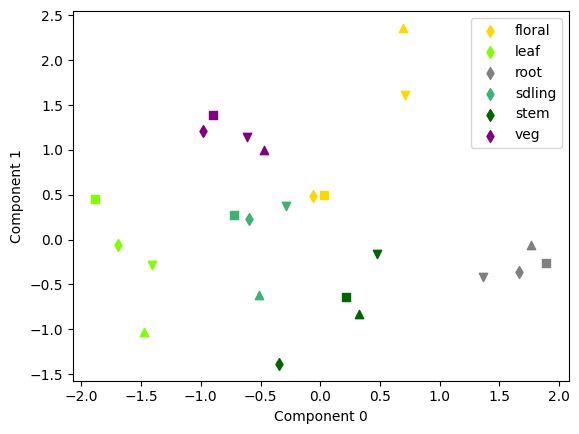

In [8]:
keras.utils.set_random_seed(42)
Y_VAE = variational_autoencoder(data[:,range(500)]) 
plot_components(Y_VAE)

The visualized encoded means form clusters by tissue type.

### Task:
1. What is the rationale behind using regularization? What can happen without regularization?
2. What is a potential drawback of regularization? What can happen if regularization is too strong? You can play with the weight of the regularization term.